## AWS Outline for LDA

In [1]:
# Main libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#from sklearn.metrics import accuracy_score, classification_reportt

### Importing Data

In [2]:
movie_data = pd.read_csv(r"/Users/alexandratorti/DS PROJECT COURSE/Project 2/wiki_movie_plots_deduped.csv")
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


Histogram 

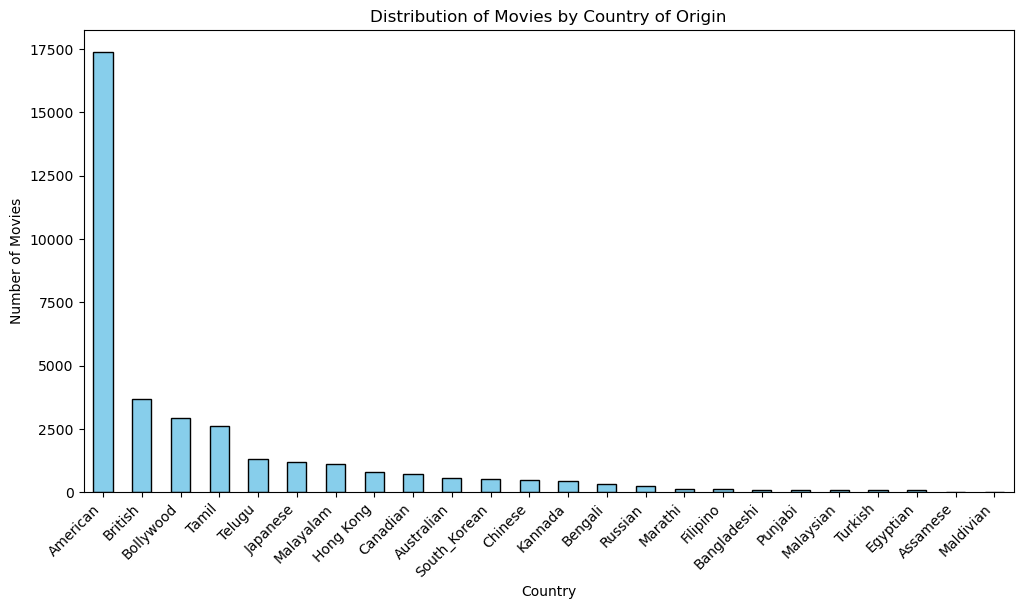

In [3]:
# Visualize the distribution of movies based on countries
plt.figure(figsize=(12, 6))
movie_data['Origin/Ethnicity'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Movies by Country of Origin')
plt.xlabel('Country')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

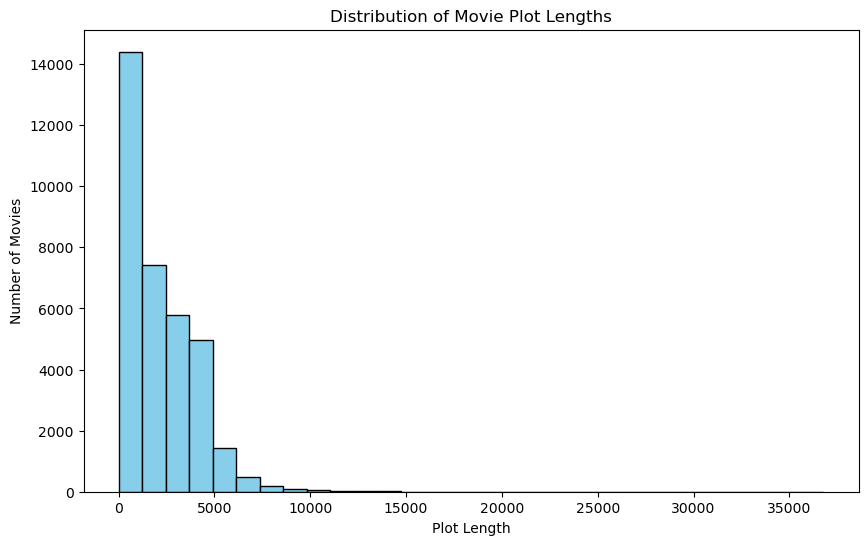

In [4]:
# Visualize the distribution of plot lengths
plt.figure(figsize=(10, 6))
plt.hist(movie_data['Plot'].str.len(), bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Plot Lengths')
plt.xlabel('Plot Length')
plt.ylabel('Number of Movies')
plt.show()

### Cleaning Data

In [5]:
# Select only films that are American in origin
us_movies = movie_data[movie_data['Origin/Ethnicity'] == 'American']

# Drop unwanted columns (Wiki.Page, Director, Cast)
us_movies = us_movies.drop(columns=['Wiki Page', 'Director', 'Cast'])

# Print the summary of the resulting DataFrame
us_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17377 entries, 0 to 17376
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      17377 non-null  int64 
 1   Title             17377 non-null  object
 2   Origin/Ethnicity  17377 non-null  object
 3   Genre             17377 non-null  object
 4   Plot              17377 non-null  object
dtypes: int64(1), object(4)
memory usage: 814.5+ KB


In [6]:
# Fetch Title and Plot columns
finaldata = us_movies[["Title", "Plot"]]

# Setting the movie title as index
finaldata = finaldata.set_index('Title')
finaldata.head()

,Plot
Title,
Kansas Saloon Smashers,"A bartender is working at a saloon, serving dr..."
Love by the Light of the Moon,"The moon, painted with a smiling face hangs ov..."
The Martyred Presidents,"The film, just over a minute long, is composed..."
"Terrible Teddy, the Grizzly King",Lasting just 61 seconds and consisting of two ...
Jack and the Beanstalk,The earliest known adaptation of the classic f...


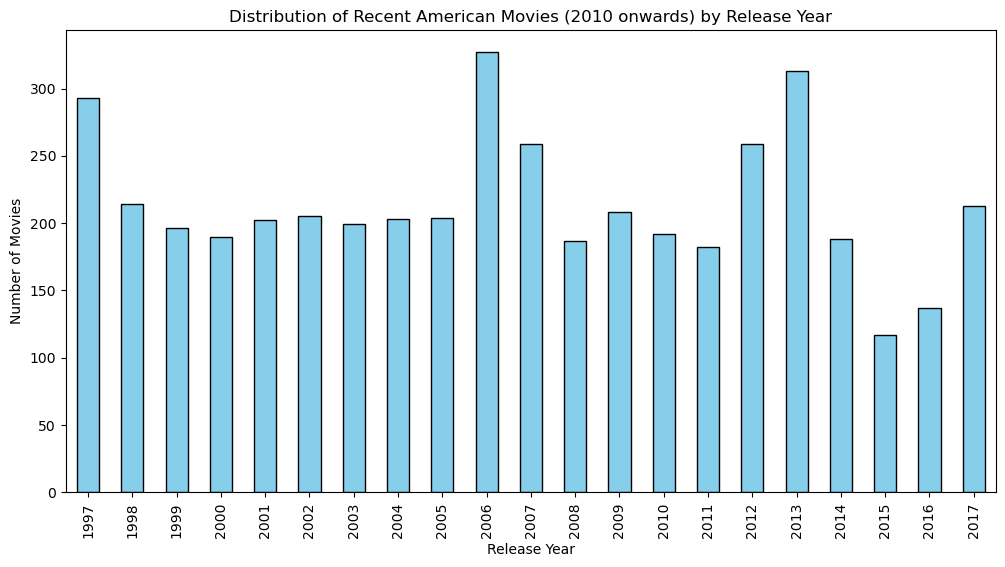

In [7]:
# Filter for recent years (e.g., from 1997 onwards)
recent_us_movies = us_movies[us_movies['Release Year'] >= 1997]

# Visualize the distribution of recent American movies by year
plt.figure(figsize=(12, 6))
recent_us_movies['Release Year'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Recent American Movies (2010 onwards) by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()



### Beginning LDA

In [8]:
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim


In [9]:
# create English stop words list
en_stop = get_stop_words('en')

In [10]:
print(en_stop)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [11]:
tokenizer = RegexpTokenizer(r'\w+')

In [12]:
# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()

In [13]:
plot_set = []
for item in recent_us_movies["Plot"]:
    modified_item = item.replace("\'s", "")  # Corrected line
    plot_set.append(modified_item)

In [14]:
print(plot_set[0:1])

['The film tells a story in the life of a Midwestern family, the Reimullers. Lori (played by Meryl Streep) is the mother of three children and the wife of Dave (Fred Ward), a truck driver. The family are presented as happy, normal and comfortable financially: they have just bought a horse and are planning a holiday to Hawaii. Then the youngest son, Robbie (Seth Adkins), has a sudden unexplained fall at school. A short while later, he has another unprovoked fall while playing with his brother, and is seen having a convulsive seizure. Robbie is taken to the hospital where a number of procedures are performed: a CT scan, a lumbar puncture, an electroencephalogram (EEG) and blood tests. No cause is found but the two falls are regarded as epileptic seizures and the child is diagnosed with epilepsy.\r\nRobbie is started on phenobarbital, an old anticonvulsant drug with well-known side effects including cognitive impairment and behavior problems. The latter cause the child to run berserk thro

In [15]:
# List for tokenized plots in a loop
texts = []

In [16]:
# Names 

# Assuming your CSV file has a column named 'custom_stop_words'
# Adjust the file path and column name accordingly
csv_file_path = '/Users/alexandratorti/DS PROJECT COURSE/names.csv'
names_df = pd.read_csv(csv_file_path)
names = names_df['name'].str.lower()
names = names.tolist()
print(names)

# First names

# Assuming your CSV file has a column named 'custom_stop_words'
# Adjust the file path and column name accordingly
csv_file_path = '/Users/alexandratorti/DS PROJECT COURSE/Project 2/babynames-clean.csv'
fnames_df = pd.read_csv(csv_file_path)
fnames = fnames_df['name'].str.lower()
fnames = fnames.tolist()
print(fnames)


['smith', 'johnson', 'williams', 'brown', 'jones', 'miller', 'davis', 'garcia', 'rodriguez', 'wilson', 'martinez', 'anderson', 'taylor', 'thomas', 'hernandez', 'moore', 'martin', 'jackson', 'thompson', 'white', 'lopez', 'lee', 'gonzalez', 'harris', 'clark', 'lewis', 'robinson', 'walker', 'perez', 'hall', 'young', 'allen', 'sanchez', 'wright', 'king', 'scott', 'green', 'baker', 'adams', 'nelson', 'hill', 'ramirez', 'campbell', 'mitchell', 'roberts', 'carter', 'phillips', 'evans', 'turner', 'torres', 'parker', 'collins', 'edwards', 'stewart', 'flores', 'morris', 'nguyen', 'murphy', 'rivera', 'cook', 'rogers', 'morgan', 'peterson', 'cooper', 'reed', 'bailey', 'bell', 'gomez', 'kelly', 'howard', 'ward', 'cox', 'diaz', 'richardson', 'wood', 'watson', 'brooks', 'bennett', 'gray', 'james', 'reyes', 'cruz', 'hughes', 'price', 'myers', 'long', 'foster', 'sanders', 'ross', 'morales', 'powell', 'sullivan', 'russell', 'ortiz', 'jenkins', 'gutierrez', 'perry', 'butler', 'barnes', 'fisher', 'henders

In [17]:
## connecting the lists 
stop_words = en_stop + names + fnames



In [18]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [19]:
# Tokenizing loop through plot list
for item in plot_set:
    
    # clean and tokenize document string
    raw = item.lower()
    tokens = tokenizer.tokenize(raw)

    # remove names and stop words from tokens
    #stopped_tokens = [item for item in tokens if item not in names and item not in en_stop]
    
    # remove names from tokens
    #stopped_tokens = [item for item in tokens if not item in names]

    # remove stop words from tokens
    stopped_tokens = [item for item in tokens if not item in stop_words]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(item) for item in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)

In [20]:
print(tokens)

['in', '1954', 'london', 'renowned', 'fashion', 'designer', 'reynolds', 'woodcock', 'creates', 'dresses', 'for', 'members', 'of', 'high', 'society', 'his', 'charisma', 'and', 'genius', 'are', 'matched', 'by', 'his', 'obsessive', 'controlling', 'and', 'sometimes', 'abusive', 'personality', 'cyril', 'his', 'sister', 'manages', 'the', 'day', 'to', 'day', 'operations', 'of', 'his', 'fashion', 'house', 'and', 'has', 'significant', 'influence', 'over', 'his', 'life', 'reynolds', 'is', 'haunted', 'by', 'the', 'death', 'of', 'their', 'mother', 'and', 'stitches', 'hidden', 'messages', 'into', 'the', 'linings', 'of', 'the', 'dresses', 'he', 'makes', 'after', 'designing', 'a', 'new', 'gown', 'for', 'a', 'revered', 'client', 'reynolds', 'visits', 'a', 'restaurant', 'in', 'the', 'countryside', 'and', 'becomes', 'interested', 'in', 'a', 'waitress', 'alma', 'he', 'asks', 'her', 'on', 'a', 'date', 'and', 'she', 'accepts', 'their', 'relationship', 'develops', 'and', 'she', 'moves', 'in', 'with', 'him',

In [21]:
print(texts[0:1])

[['film', 'tell', 'stori', 'life', 'midwestern', 'famili', 'reimul', 'play', 'streep', 'mother', 'three', 'children', 'wife', 'truck', 'driver', 'famili', 'present', 'happi', 'normal', 'comfort', 'financi', 'just', 'bought', 'hors', 'plan', 'holiday', 'hawaii', 'youngest', 'sudden', 'unexplain', 'fall', 'school', 'later', 'anoth', 'unprovok', 'fall', 'play', 'brother', 'seen', 'convuls', 'seizur', 'taken', 'hospit', 'number', 'procedur', 'perform', 'ct', 'scan', 'lumbar', 'punctur', 'electroencephalogram', 'eeg', 'blood', 'test', 'caus', 'found', 'two', 'fall', 'regard', 'epilept', 'seizur', 'child', 'diagnos', 'epilepsi', 'start', 'phenobarbit', 'old', 'anticonvuls', 'drug', 'well', 'known', 'side', 'effect', 'includ', 'cognit', 'impair', 'behavior', 'problem', 'latter', 'caus', 'child', 'run', 'berserk', 'lead', 'injuri', 'urgent', 'phone', 'physician', 'request', 'chang', 'medic', 'chang', 'phenytoin', 'dilantin', 'dose', 'phenobarbit', 'must', 'taper', 'slowli', 'caus', 'frustrat',

In [22]:
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)

In [23]:
print(dictionary)

Dictionary<34873 unique tokens: ['1940', 'abbasac', 'abduct', 'accept', 'accompani']...>


In [24]:
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]

In [25]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.ldamodel import LdaModel

In [95]:
# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=50, id2word = dictionary, passes=20)

In [96]:
print(ldamodel.print_topics(num_topics=50, num_words=4))

[(0, '0.030*"beal" + 0.020*"cage" + 0.019*"hulk" + 0.017*"second"'), (1, '0.062*"c" + 0.056*"b" + 0.051*"w" + 0.039*"cruso"'), (2, '0.020*"amsterdam" + 0.020*"mama" + 0.016*"milkshak" + 0.016*"templeton"'), (3, '0.041*"sparkl" + 0.033*"em" + 0.030*"satin" + 0.024*"sinatra"'), (4, '0.047*"wed" + 0.020*"parti" + 0.015*"girl" + 0.015*"fratern"'), (5, '0.037*"madea" + 0.036*"mr" + 0.019*"halloran" + 0.018*"wand"'), (6, '0.056*"school" + 0.022*"student" + 0.016*"girl" + 0.016*"high"'), (7, '0.061*"team" + 0.057*"game" + 0.026*"player" + 0.020*"win"'), (8, '0.072*"dragon" + 0.032*"machet" + 0.032*"bam" + 0.019*"sand"'), (9, '0.039*"drug" + 0.024*"cia" + 0.019*"bourn" + 0.014*"cartel"'), (10, '0.011*"new" + 0.011*"k" + 0.009*"citi" + 0.009*"robot"'), (11, '0.014*"polic" + 0.009*"car" + 0.009*"kill" + 0.008*"offic"'), (12, '0.070*"o" + 0.050*"mowgli" + 0.028*"chi" + 0.021*"baloo"'), (13, '0.078*"47" + 0.042*"vasili" + 0.033*"snake" + 0.031*"orphanag"'), (14, '0.029*"camp" + 0.024*"d" + 0.021*"

In [37]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.4563162157372487


In [38]:
# supporting function
def compute_coherence_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=35, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [93]:
# Iterate over possible number of topics. takes about 2-3mins
topic_param = [0, 10,15,20,30,35, 40, 50, 65]
coherence_score = []

for k in topic_param:
    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k)
    coherence_score.append(cv)

param_tuning_coherence = pd.DataFrame()
param_tuning_coherence["topic_param"] = topic_param
param_tuning_coherence['coherence_score'] = coherence_score
param_tuning_coherence

,topic_param,coherence_score
0,0,0.485917
1,10,0.486717
2,15,0.488906
3,20,0.489603
4,30,0.485481
5,35,0.490353
6,40,0.487553
7,50,0.496039
8,65,0.487178


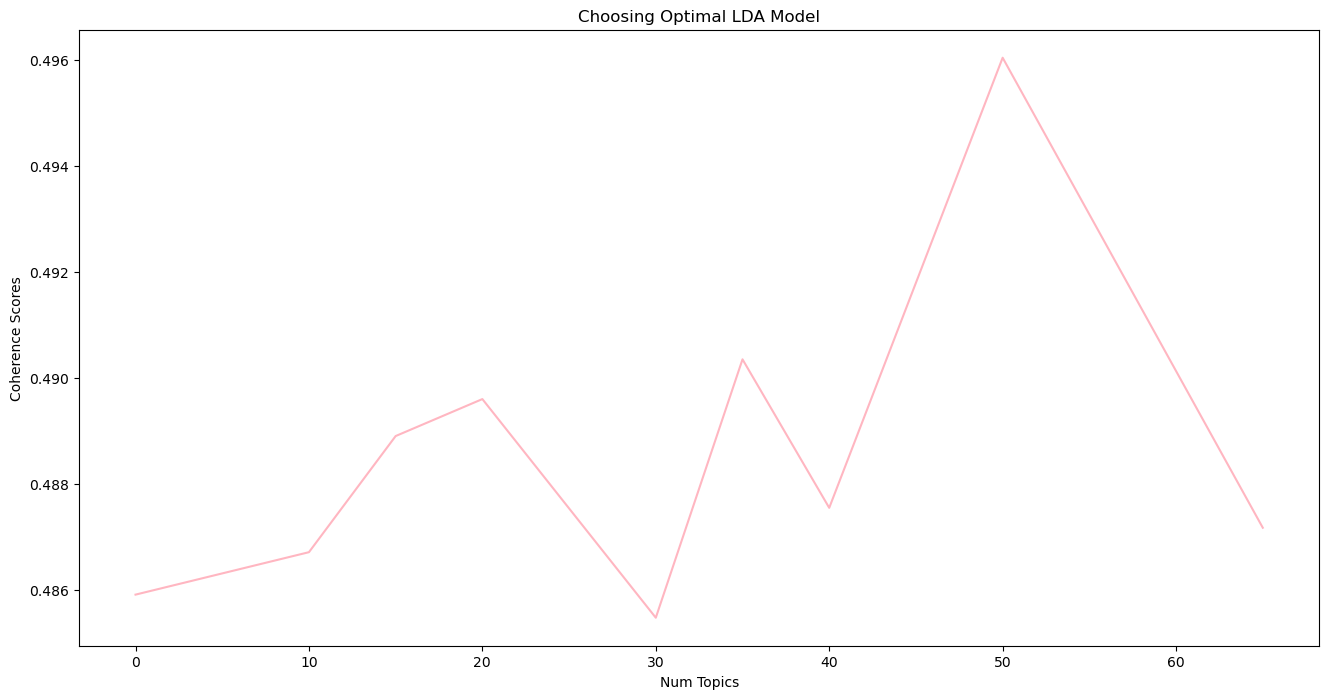

In [131]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, param_tuning_coherence['coherence_score'],color='lightpink')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

In [97]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True)) 

In [98]:
#document topic matrix
doc_num, topic_num, prob = [], [], []
print(ldamodel.get_document_topics(corpus))
for n in range(len(recent_us_movies)):
    get_document_topics = ldamodel.get_document_topics(corpus[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
recent_us_movies['Doc'] = doc_num
recent_us_movies['Topic'] = topic_num
recent_us_movies['Probability'] = prob
recent_us_movies.to_csv('doc_topic_matrix.csv', index=False)

/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_68186/4081826330.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_us_movies['Doc'] = doc_num
/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_68186/4081826330.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_us_movies['Topic'] = topic_num
/var/folders/55/4w5l1r5x0618j7pxmq4kdgmr0000gn/T/ipykernel_68186/4081826330.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [99]:
# Reset the index to move titles back to a column
finaldata_reset = recent_us_movies.reset_index()
finaldata_reset['Title'] = finaldata_reset['Title'].str.title()

# Now, 'Title' is a regular column
print(finaldata_reset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4488 entries, 0 to 4487
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             4488 non-null   int64  
 1   Release Year      4488 non-null   int64  
 2   Title             4488 non-null   object 
 3   Origin/Ethnicity  4488 non-null   object 
 4   Genre             4488 non-null   object 
 5   Plot              4488 non-null   object 
 6   Doc               4488 non-null   int64  
 7   Topic             4488 non-null   int64  
 8   Probability       4488 non-null   float32
dtypes: float32(1), int64(4), object(4)
memory usage: 298.2+ KB
None


In [100]:
#Recomendation Function
def recommend_by_storyline(title):
    recommended = []
    top10_list = []
    title = title.lower()
    finaldata_reset['Title'] = finaldata_reset['Title'].str.lower()
    topic_num = finaldata_reset[finaldata_reset['Title']==title].Topic.values
    doc_num = finaldata_reset[finaldata_reset['Title']==title].Doc.values 
    
    output_df = finaldata_reset[finaldata_reset['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)
    index = output_df[output_df['Doc']==doc_num[0]].index[0]
    
    top10_list += list(output_df.iloc[index-5:index].index)
    # top10_list += list(output_df.iloc[index+1:index+6].index)
    
    output_df['Title'] = output_df['Title'].str.title()
    
    for each in top10_list:
        recommended.append(output_df.iloc[each]['Title'])
    
    return recommended

In [151]:
# Assuming 'finaldata' is your DataFrame
random_movie = finaldata_reset['Title'].sample().values[0]
print("Random Movie Name:", random_movie)

Random Movie Name: mamma mia!


In [153]:
recommend_by_storyline("This is 40")

['Any Day Now',
 'Think Like A Man',
 'The Business Of Strangers',
 'The Squid And The Whale',
 'Wonderful World']

In [161]:
def top_topics(title, lda_model):
    # Convert input title to lowercase
    # Convert input title to lowercase
    title = title.lower()

    # Convert all titles in the dataset to lowercase for case-insensitive comparison
    finaldata_reset['Title'] = finaldata_reset['Title'].str.lower()

    # Find the topic and document number for the input title
    topic_num = finaldata_reset[finaldata_reset['Title'] == title]['Topic'].values
    doc_num = finaldata_reset[finaldata_reset['Title'] == title]['Doc'].values

    # Filter movies with the same topic as the input title and sort by probability
    output_df = finaldata_reset[finaldata_reset['Topic'] == topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)

    # Find the index of the input title in the sorted dataframe
    index = output_df[output_df['Doc'] == doc_num[0]].index[0]

    # Get the document's topic distribution from the LDA model
    doc_index = int(output_df.iloc[index]['Doc'])  # Convert to int
    doc_topic_distribution = lda_model[doc_index]

    return doc_topic_distribution

In [162]:
print(top_topics('Coco', ldamodel))

TypeError: object of type 'int' has no len()